### Information Retrieval Coursework (STW7071CEM)

Task: Develop a document clustering system.

First, collect a number of documents that belong to different categories, namely Politics, Economics and Entertainment. Each document should be at least one sentence (the longer is usually the better). The total number of documents is up to you but should be at least 100 (the more is usually the better).

Once you have collected sufficient documents, cluster them using a standard clustering method (e.g. K-means).

Finally, use the created model to assign a new document to one of the existing clusters. That is, the user enters a document (e.g. a sentence) and your system outputs the right cluster.

### Importing Modules

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
# from scipy import interp


# # Visualuzation
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

### Load Dataset

In [2]:
df = pd.read_csv('database_csv.csv',encoding='latin1')
df = df[df['Cluster_Name'].isin(['Politics','Entertainment','Economics'])]
print(df.shape)
df.head()


(111, 3)


,Document,Cluster,Cluster_Name
0,Trying to understand it for the first time or ...,1.0,Politics
1,President Biden has upended the 2024 White Ho...,1.0,Politics
2,The junior senator from Ohio shot to fame writ...,1.0,Politics
3,A very quick guide to Donald Trump's life story.,1.0,Politics
4,The daughter of an Indian-born mother and Jama...,1.0,Politics


In [3]:
print(df.columns)

Index(['Document', 'Cluster', 'Cluster_Name'], dtype='object')


In [4]:
df.drop(columns=['Cluster'], inplace=True)
df.head()

,Document,Cluster_Name
0,Trying to understand it for the first time or ...,Politics
1,President Biden has upended the 2024 White Ho...,Politics
2,The junior senator from Ohio shot to fame writ...,Politics
3,A very quick guide to Donald Trump's life story.,Politics
4,The daughter of an Indian-born mother and Jama...,Politics


### Exploring the Dataset

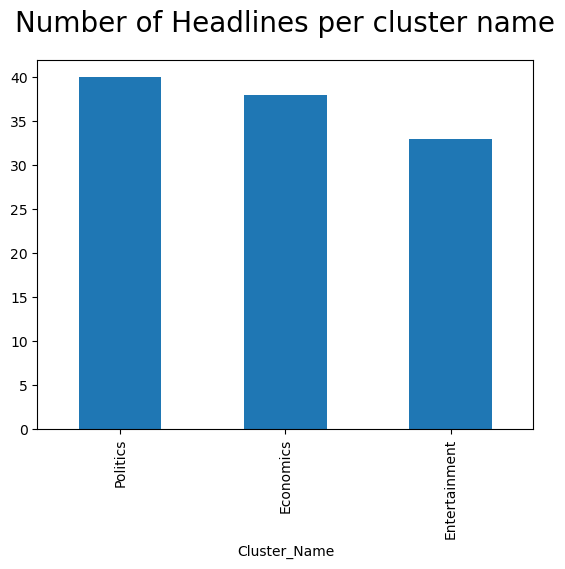

In [5]:
df['Cluster_Name'].value_counts().plot(kind='bar')
plt.title('Number of Headlines per cluster name', size=20, pad=20);

In [6]:
#Checking for missing values
df.isna().sum()

Document        0
Cluster_Name    0
dtype: int64

### Text Preprocessing

We will now clean the text by removing special characters and punctuations.

In [7]:
def preprocess(df):
    # Remove special characters
    df['Document-pro'] = df['Document'].replace('\n',' ')
    df['Document-pro'] = df['Document-pro'].replace('\r',' ')
    
    # Remove punctuation and lowercase
    df['Document-pro'] = df['Document-pro'].str.lower()
    df['Document-pro'] = df['Document-pro'].str.translate(str.maketrans('','',string.punctuation))
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}
        return hash_tag.get(tag, wordnet.NOUN)


    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax

    df['Document-pro'] = df['Document-pro'].apply(lematize)

In [8]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\Yash
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yash
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yash
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yash Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
preprocess(df)

### Preprocessing Demonstration

**Before Pre-processing:**

In [10]:
df.iloc[0]['Document']

'Trying to understand it for the first time or need a refresher? This guide can help.'

**After Pre-processing**

In [11]:
df.iloc[0]['Document-pro']

'try understand first time need refresher guide help '

### Train Test Split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df['Document-pro'],
                                                    df['Cluster_Name'],
                                                    test_size=0.25,
                                                    random_state=42)

Check for acceptable category balance

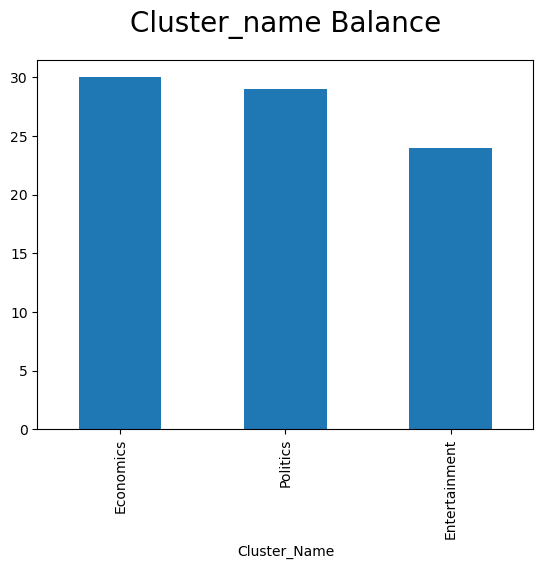

In [33]:
y_train.value_counts().plot(kind='bar')
plt.title('Cluster_name Balance', size=20, pad=20);

In [14]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(83,) (28,) (83,) (28,)


### Vectorize

In [15]:
vector = TfidfVectorizer(stop_words='english',
                        ngram_range = (1,2),
                        min_df = 3,
                        max_df = 0.7,
                        max_features = 10000)

In [16]:
# Fit Decision Tree Model
def fit_decision_tree(x_train, y_train):
    line = Pipeline([('vectorize', vector), ('DecisionTree', DecisionTreeClassifier())])
    line.fit(x_train, y_train)
    return line

decision_tree_model = fit_decision_tree(x_train, y_train)

# Evaluate the Decision Tree Model
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

decision_tree_metrics = evaluate_model(decision_tree_model, x_test, y_test)
print(f"Decision Tree Metrics:\nAccuracy: {decision_tree_metrics[0]}\nPrecision: {decision_tree_metrics[1]}\nRecall: {decision_tree_metrics[2]}\nF1 Score: {decision_tree_metrics[3]}")

Decision Tree Metrics:
Accuracy: 0.5357142857142857
Precision: 0.6126373626373626
Recall: 0.5357142857142857
F1 Score: 0.5523088023088023


In [17]:
# Fit KMeans Model
def fit_kmeans(x_train):
    line = Pipeline([('vectorize', vector), ('KMeans', KMeans(n_clusters=3, random_state=42))])
    line.fit(x_train)
    return line

kmeans_model = fit_kmeans(x_train)

# Predict with KMeans Model
def predict_kmeans(model, x_test):
    return model.predict(x_test)

kmeans_predictions = predict_kmeans(kmeans_model, x_test)
print(f"KMeans Cluster Predictions: {np.unique(kmeans_predictions, return_counts=True)}")

KMeans Cluster Predictions: (array([0, 1, 2]), array([ 1,  1, 26], dtype=int64))


In [18]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

# Fit KMeans Model
def fit_kmeans(x_train):
    line = Pipeline([('vectorize', vector), ('KMeans', KMeans(n_clusters=3, random_state=42))])
    line.fit(x_train)
    return line

kmeans_model = fit_kmeans(x_train)

# Predict with KMeans Model
def predict_kmeans(model, x_test):
    return model.predict(x_test)

kmeans_predictions = predict_kmeans(kmeans_model, x_test)
print(f"KMeans Cluster Predictions: {np.unique(kmeans_predictions, return_counts=True)}")

# Since KMeans is unsupervised, we use clustering evaluation metrics
silhouette_avg = silhouette_score(vector.transform(x_test), kmeans_predictions)
print(f"Silhouette Score: {silhouette_avg}")

# If you have the true labels, you can compare the cluster labels with true labels
# In this case, using the Cluster_Name as ground truth
adjusted_rand = adjusted_rand_score(y_test, kmeans_predictions)
homogeneity = homogeneity_score(y_test, kmeans_predictions)
completeness = completeness_score(y_test, kmeans_predictions)
v_measure = v_measure_score(y_test, kmeans_predictions)

print(f"Adjusted Rand Index: {adjusted_rand}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")


KMeans Cluster Predictions: (array([0, 1, 2]), array([ 1,  1, 26], dtype=int64))
Silhouette Score: 0.11792345140029979
Adjusted Rand Index: -0.01098561039764815
Homogeneity: 0.06884407175346471
Completeness: 0.2445207163287763
V-Measure: 0.10743901280783928


### Model Construction

### Selecting a Model

In [19]:
x = pd.concat([x_train,
               x_test])
y = pd.concat([y_train,
               y_test])

In [20]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize',vector), ('model',best_clf)])
    return pipeline.fit(x,y)

In [21]:
classifier = create_and_fit(DecisionTreeClassifier(),x,y)

In [22]:
classifier.classes_

array(['Economics', 'Entertainment', 'Politics'], dtype=object)

### Final Testing

This text is extracted through Google News from the Entertainment Section.
The classifier should predict the text as "Entertainment"

In [23]:
input_text = 'A 34%, three-day surge in SoftBank Group Corp. has pushed its shares to the most overbought level in more than two decades on the back of Arm Holdings Plc.’s explosive rally.'
classifier.predict_proba([input_text])

array([[0.44444444, 0.55555556, 0.        ]])

In [24]:
classifier.predict([input_text])[0]

'Entertainment'

### GUI

In [ ]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText
from tkinter import messagebox, font

def result(res, pr):
    ECONOMICS = round(pr[0][0], 3)
    POLITICS = round(pr[0][1], 3)
    ENTERTAINMENT = round(pr[0][2], 3)

    lines = [f"POLITICS: {POLITICS}", f"ECONOMICS: {ECONOMICS}", f"ENTERTAINMENT: {ENTERTAINMENT}"]
    messagebox.showinfo(
        message=f"Predicted Category: {str(res).capitalize()}" + "\n\n\n" + "\n".join(lines)
    )

def clickMe():
    classification = tk.StringVar()
    category_, probabilities = classify_text(text_box.get("1.0", tk.END))
    result(category_, probabilities)

def classify_text(input_text):
    out = classifier.predict([input_text])[0]
    probs = classifier.predict_proba([input_text])
    return out, probs

window = tk.Tk()
window.title("TEXT CLASSIFIER_YashRajBista")
window.minsize(600, 400)

# Set a custom font
custom_font = font.Font(family="Comic Sans MS", size=12, weight="bold")

# Set window background color to a brighter shade
window.configure(bg="#FFD700")  # Bright yellow

# Create a frame with a different brighter background color
frame = tk.Frame(window, padx=10, pady=10, bg="#FFFFFF")  # white color
frame.pack(expand=True, fill=tk.BOTH)

label = tk.Label(frame, text="Enter Text to be classified", font=custom_font, bg="#FFEC8B", fg="#005500")  # Dark green text
label.grid(column=0, row=0, pady=(0, 5))

text_box = ScrolledText(frame, wrap=tk.WORD, height=10, font=custom_font, bg="#FFFFFF", fg="#005500", insertbackground="#FFFFFF")
text_box.grid(column=0, row=1, padx=5, pady=5)

btn = tk.Button(frame, text="Classify", command=clickMe, font=custom_font, bg="#A9A9A9", fg="cyan", activebackground="#696969")  # Gray button
btn.grid(column=0, row=2, pady=(5, 0))

window.mainloop()

